# Processamento de Linguagem Natural (PLN)

_Natural Language Processing (NLP) em Inglês_


## Análise de Sentimentos - Twitter

Identificar se o tweet é **racista/sexista** ou **não**


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Ler dados


In [2]:
train = pd.read_csv('twitter/train.csv')
test = pd.read_csv('twitter/test.csv')

In [3]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## Pré-processamento de Dados


### Tirar pontuações e caracteres especiais


In [6]:
# Expressão Regular
# r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"

In [7]:
def clean_text(data, col):
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(lambda x: re.sub(
        r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '', x))

In [8]:
clean_text(train, 'tweet')
train.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [9]:
clean_text(test, 'tweet')
test.head()

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,white supremacists want everyone to see the ...
2,31965,safe ways to heal your acne altwaystoheal h...
3,31966,is the hp and the cursed child book up for res...
4,31967,3rd bihday to my amazing hilarious nephew el...


### Remover palavras comuns


In [10]:
comum_words = stopwords.words('english')

In [11]:
len(comum_words)

179

In [12]:
[word for word in train['tweet'].str.split()[0] if word not in comum_words]

['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunction', 'run']

In [13]:
def remove_comum_words(data, col):
    list_of_list_of_words = data['tweet'].str.split()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [word for word in list_of_list_of_words[idx]
                             if word not in comum_words]

In [14]:
remove_comum_words(train, 'tweet')

In [15]:
train.head()

,id,label,tweet
0,1,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,2,0,"[thanks, lyft, credit, cant, use, cause, dont,..."
2,3,0,"[bihday, majesty]"
3,4,0,"[model, love, u, take, u, time, ur]"
4,5,0,"[factsguide, society, motivation]"


In [16]:
remove_comum_words(test, 'tweet')

In [17]:
test.head()

,id,tweet
0,31963,"[studiolife, aislife, requires, passion, dedic..."
1,31964,"[white, supremacists, want, everyone, see, new..."
2,31965,"[safe, ways, heal, acne, altwaystoheal, health..."
3,31966,"[hp, cursed, child, book, reservations, alread..."
4,31967,"[3rd, bihday, amazing, hilarious, nephew, eli,..."


### Remover variações da mesma palavra


In [18]:
remove_variation = WordNetLemmatizer()

In [19]:
remove_variation.lemmatize('was', 'v')

'be'

In [20]:
[remove_variation.lemmatize(word, 'v') for word in train['tweet'][31957]]

['eat', 'isz', 'youuu']

In [21]:
def remove_words_variation(data, col):
    for idx, _ in data.iterrows():
        data[col].at[idx] = [remove_variation.lemmatize(word, 'v')
                             for word in data[col][idx]]

In [22]:
remove_words_variation(train, 'tweet')
train.tail()

,id,label,tweet
31957,31958,0,"[eat, isz, youuu]"
31958,31959,0,"[see, nina, turner, airwaves, try, wrap, mantl..."
31959,31960,0,"[listen, sad, songs, monday, morning, otw, wor..."
31960,31961,1,"[sikh, temple, vandalise, calgary, wso, condem..."
31961,31962,0,"[thank, follow]"


In [23]:
remove_words_variation(test, 'tweet')
test.head()

,id,tweet
0,31963,"[studiolife, aislife, require, passion, dedica..."
1,31964,"[white, supremacists, want, everyone, see, new..."
2,31965,"[safe, ways, heal, acne, altwaystoheal, health..."
3,31966,"[hp, curse, child, book, reservations, already..."
4,31967,"[3rd, bihday, amaze, hilarious, nephew, eli, a..."


### Engenharia de Recursos (Feature Engineering )

#### Quantidade de palavras por tweet


In [24]:
train['words'] = train['tweet'].apply(len)

In [25]:
train

,id,label,tweet,words
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3
...,...,...,...,...
31957,31958,0,"[eat, isz, youuu]",3
31958,31959,0,"[see, nina, turner, airwaves, try, wrap, mantl...",14
31959,31960,0,"[listen, sad, songs, monday, morning, otw, wor...",8
31960,31961,1,"[sikh, temple, vandalise, calgary, wso, condem...",7


In [26]:
test['words'] = test['tweet'].apply(len)
test

,id,tweet,words
0,31963,"[studiolife, aislife, require, passion, dedica...",8
1,31964,"[white, supremacists, want, everyone, see, new...",9
2,31965,"[safe, ways, heal, acne, altwaystoheal, health...",7
3,31966,"[hp, curse, child, book, reservations, already...",10
4,31967,"[3rd, bihday, amaze, hilarious, nephew, eli, a...",11
...,...,...,...
17192,49155,"[think, factory, leftright, polarisation, trum...",11
17193,49156,"[feel, like, mermaid, hairflip, neverready, fo...",10
17194,49157,"[hillary, campaign, today, ohioomg, amp, use, ...",14
17195,49158,"[happy, work, conference, right, mindset, lead...",10


## Análise Exploratória de Dados (AED)


### Distribuição das quantidades de palavras por "label"


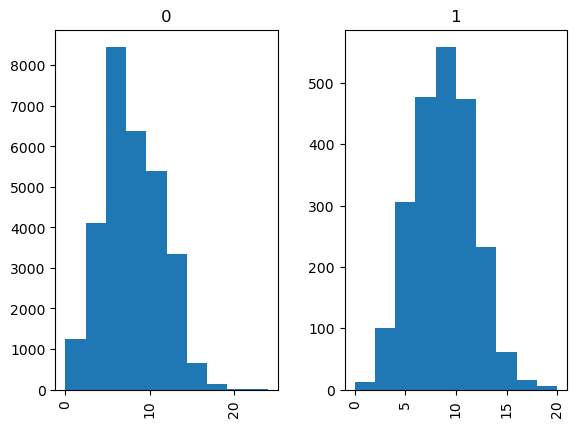

In [27]:
train.hist(column=['words'], by='label')
plt.show()

### Quantidade de cada "label"


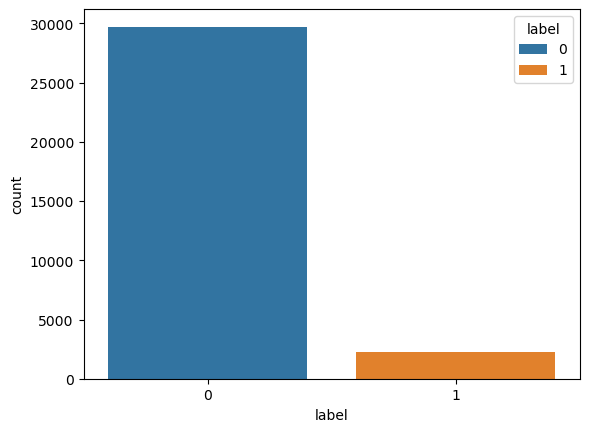

In [28]:
sns.countplot(train, x='label', hue='label')
plt.show()

### Palavras frequêntes

#### Averiguar palavras mais frequêntes classificadas como "racistas ou sexistas"


In [29]:
list_of_lists = train.loc[train['label'] == 1]['tweet'].values
list_of_lists

array([list(['cnn', 'call', 'michigan', 'middle', 'school', 'build', 'wall', 'chant', 'tcot']),
       list(['comment', 'australia', 'opkillingbay', 'seashepherd', 'helpcovedolphins', 'thecove', 'helpcovedolphins']),
       list(['retweet', 'agree']), ...,
       list(['dont', 'ball', 'hashtag', 'say', 'weasel', 'away', 'lumpy', 'tony', 'dipshit']),
       list(['make', 'ask', 'anybody', 'god', 'oh', 'thank', 'god']),
       list(['sikh', 'temple', 'vandalise', 'calgary', 'wso', 'condemn', 'act'])],
      dtype=object)

In [30]:
words = [word for _list in list_of_lists for word in _list]

In [31]:
len(words)

18596

In [32]:
from collections import Counter


def gen_word_freq(_list):
    return Counter(_list)

In [34]:
words_freq = gen_word_freq(words)

In [35]:
len(words_freq)

5285

In [36]:
list_of_words = []
freq_list = []
for word, freq in words_freq.items():
    list_of_words.append(word)
    freq_list.append(freq)

In [38]:
list_of_words

['cnn',
 'call',
 'michigan',
 'middle',
 'school',
 'build',
 'wall',
 'chant',
 'tcot',
 'comment',
 'australia',
 'opkillingbay',
 'seashepherd',
 'helpcovedolphins',
 'thecove',
 'retweet',
 'agree',
 'lumpy',
 'say',
 'prove',
 'unbelievable',
 '21st',
 'century',
 'wed',
 'need',
 'something',
 'like',
 'neverump',
 'xenophobia',
 'let',
 'fight',
 'love',
 'peace',
 'white',
 'establishment',
 'cant',
 'blk',
 'folx',
 'run',
 'around',
 'promote',
 'greatness',
 'hey',
 'people',
 'race',
 'identity',
 'med',
 'altright',
 'use',
 'amp',
 'insecurity',
 'lure',
 'men',
 'whitesupremacy',
 'im',
 'interest',
 'linguistics',
 'doesnt',
 'address',
 'racism',
 'power',
 'raciolinguistics',
 'bring',
 'mock',
 'obama',
 'black',
 'brexit',
 'arent',
 'protest',
 'trump',
 'republican',
 'wonthey',
 'fuhered',
 'yes',
 'michelleobama',
 'gorilla',
 'racists',
 'long',
 'think',
 'bet',
 'smaller',
 'hand',
 'show',
 'barry',
 'probably',
 'lie',
 'knicks',
 'game',
 'suck',
 'golf',

In [39]:
freq_list

[15,
 63,
 2,
 2,
 22,
 6,
 11,
 3,
 14,
 51,
 7,
 2,
 21,
 3,
 2,
 67,
 11,
 6,
 96,
 9,
 4,
 2,
 2,
 3,
 44,
 3,
 141,
 8,
 13,
 32,
 16,
 33,
 9,
 153,
 2,
 37,
 3,
 3,
 10,
 6,
 11,
 2,
 12,
 95,
 43,
 1,
 1,
 28,
 26,
 283,
 2,
 2,
 40,
 6,
 45,
 6,
 1,
 18,
 3,
 64,
 12,
 1,
 7,
 2,
 68,
 146,
 29,
 18,
 18,
 216,
 13,
 11,
 11,
 9,
 8,
 6,
 6,
 6,
 60,
 2,
 1,
 8,
 36,
 1,
 2,
 20,
 1,
 11,
 7,
 2,
 10,
 48,
 1,
 4,
 33,
 27,
 1,
 77,
 149,
 74,
 82,
 97,
 21,
 5,
 47,
 23,
 66,
 1,
 5,
 8,
 2,
 41,
 8,
 5,
 16,
 34,
 67,
 21,
 15,
 2,
 36,
 1,
 10,
 11,
 3,
 2,
 1,
 9,
 5,
 9,
 16,
 1,
 4,
 6,
 1,
 1,
 1,
 5,
 22,
 32,
 25,
 3,
 3,
 2,
 5,
 2,
 3,
 39,
 54,
 62,
 1,
 12,
 5,
 2,
 2,
 13,
 2,
 2,
 2,
 34,
 7,
 5,
 9,
 30,
 21,
 16,
 11,
 10,
 103,
 17,
 13,
 6,
 2,
 2,
 4,
 3,
 4,
 21,
 1,
 2,
 1,
 28,
 3,
 1,
 1,
 1,
 34,
 6,
 9,
 2,
 18,
 2,
 6,
 2,
 3,
 13,
 3,
 2,
 2,
 3,
 2,
 4,
 1,
 10,
 9,
 6,
 12,
 4,
 6,
 13,
 3,
 9,
 36,
 5,
 4,
 3,
 6,
 4,
 1,
 25,
 2,
 63,
 48,
 32,


In [40]:
data_freq = pd.DataFrame({
    'word': list_of_words,
    'freq': freq_list
})

In [44]:
data_freq.sort_values('freq', ascending=False, inplace=True)

### Nuvem de Palavras


In [45]:
from wordcloud import WordCloud

In [46]:
cloud = WordCloud(background_color='white')

In [58]:
cloud_dict = dict(data_freq[:50].values)

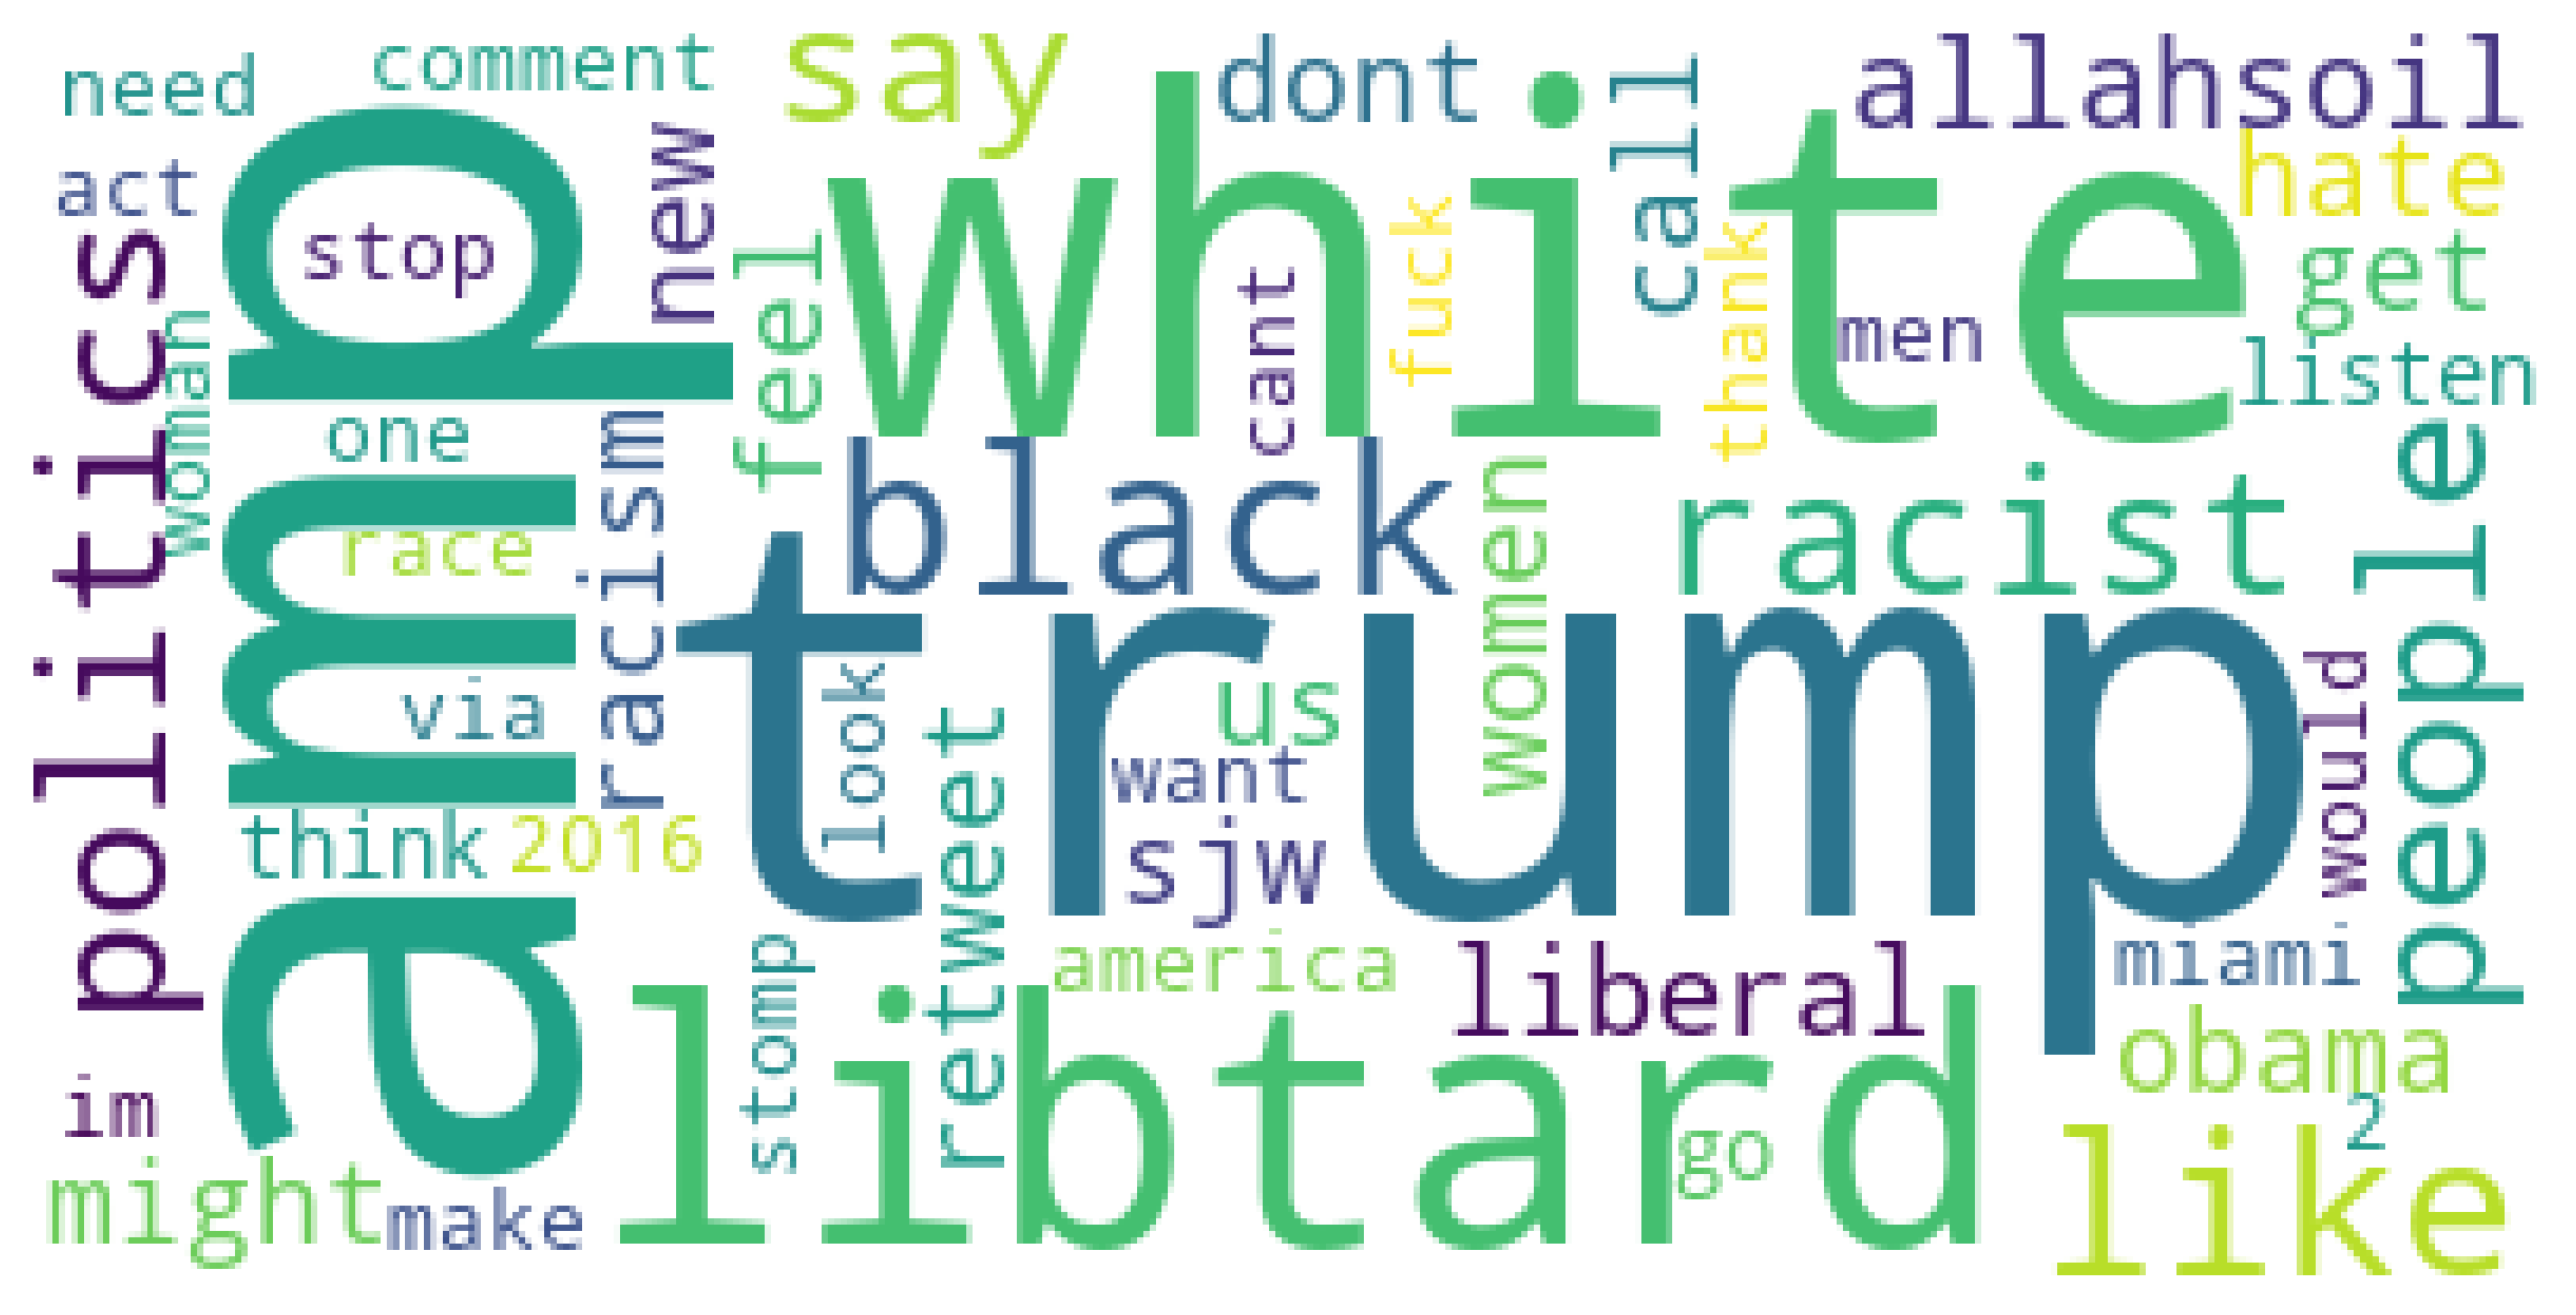

In [59]:
plt.figure(figsize=(12, 8), dpi=300)
cloud.generate_from_frequencies(cloud_dict)
plt.imshow(cloud)
plt.axis('off')
plt.show()

### Retornar para formato de texto


In [62]:
train['tweet'] = train['tweet'].apply(lambda x: ' '.join(x))

In [65]:
train

,id,label,tweet,words
0,1,0,father dysfunctional selfish drag kid dysfunct...,7
1,2,0,thank lyft credit cant use cause dont offer wh...,13
2,3,0,bihday majesty,2
3,4,0,model love u take u time ur,7
4,5,0,factsguide society motivation,3
...,...,...,...,...
31957,31958,0,eat isz youuu,3
31958,31959,0,see nina turner airwaves try wrap mantle genui...,14
31959,31960,0,listen sad songs monday morning otw work sad,8
31960,31961,1,sikh temple vandalise calgary wso condemn act,7


In [64]:
test['tweet'] = test['tweet'].apply(lambda x: ' '.join(x))

In [66]:
test

,id,tweet,words
0,31963,studiolife aislife require passion dedication ...,8
1,31964,white supremacists want everyone see new bird ...,9
2,31965,safe ways heal acne altwaystoheal healthy heal,7
3,31966,hp curse child book reservations already yes h...,10
4,31967,3rd bihday amaze hilarious nephew eli ahmir un...,11
...,...,...,...
17192,49155,think factory leftright polarisation trump use...,11
17193,49156,feel like mermaid hairflip neverready formal w...,10
17194,49157,hillary campaign today ohioomg amp use word li...,14
17195,49158,happy work conference right mindset lead cultu...,10


### Solucionar problema de desequilibrio dos dados


In [67]:
train['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [68]:
from sklearn.utils import resample

In [76]:
def balanced_data(train, for_more=True):
    train_minority = train.loc[train['label'] == 1]
    train_majority = train.loc[train['label'] == 0]
    if for_more:
        minor_to_major = resample(train_minority, replace=True,
                                  n_samples=len(train_majority), random_state=123)
        train_balanced = pd.concat(
            [minor_to_major, train_majority])  # type:ignore

    else:
        major_to_minor = resample(train_majority, replace=True,
                                  n_samples=len(train_minority), random_state=123)
        train_balanced = pd.concat(
            [major_to_minor, train_minority])  # type:ignore

    return train_balanced

In [80]:
train_balanced_plus = balanced_data(train)
train_balanced_minus = balanced_data(train, for_more=False)
len(train_balanced_plus), len(train_balanced_minus)

(59440, 4484)

In [82]:
train_balanced_plus['label'].value_counts(
), train_balanced_minus['label'].value_counts()

(label
 1    29720
 0    29720
 Name: count, dtype: int64,
 label
 0    2242
 1    2242
 Name: count, dtype: int64)

## Treinar Modelo


In [83]:
from sklearn.model_selection import train_test_split

In [86]:
X = train_balanced_plus['tweet']
y = train_balanced_plus['label']
X2 = train_balanced_minus['tweet']
y2 = train_balanced_minus['label']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2, y2, test_size=0.3, random_state=123)

In [88]:
X_train.shape, y_train.shape, X_train2.shape, y_train2.shape

((41608,), (41608,), (3138,), (3138,))

In [89]:
X_test.shape, y_test.shape, X_test2.shape, y_test2.shape

((17832,), (17832,), (1346,), (1346,))

In [90]:
sgd = Pipeline([
    ('countVector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', SGDClassifier())
])

In [91]:
sgd.fit(X_train, y_train)

Pipeline(steps=[('countVector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', SGDClassifier())])

In [92]:
sgd_pred = sgd.predict(X_test)

In [93]:
sgd_pred

array([0, 1, 1, ..., 1, 0, 1])

## Avaliar Performance do Modelo


In [94]:
from sklearn.metrics import f1_score

In [95]:
sgd_score = f1_score(y_test, sgd_pred)

In [96]:
sgd_score

0.967257467837226

In [100]:
y_pred = sgd.predict(test['tweet'])
y_pred

array([0, 1, 0, ..., 1, 0, 0])

In [102]:
sgd.fit(X_train2, y_train2)

Pipeline(steps=[('countVector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('model', SGDClassifier())])

In [104]:
sgd_pred2 = sgd.predict(X_test2)

In [106]:
sgd_pred2

array([0, 0, 0, ..., 0, 0, 1])

In [110]:
sgd_score2 = f1_score(y_test2, sgd_pred2)
sgd_score2

0.8469696969696969

In [109]:
y_pred2 = sgd.predict(test['tweet'])
y_pred2

array([0, 1, 0, ..., 1, 0, 1])

## Submissão


In [111]:
submission1 = pd.DataFrame({'id': test['id'], 'label': y_pred})
submission2 = pd.DataFrame({'id': test['id'], 'label': y_pred2})

In [113]:
submission1

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,1
17195,49158,0


In [114]:
submission2

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,1
17195,49158,0


In [115]:
submission1.to_csv('pred_twitter1.csv', index=False)
submission2.to_csv('pred_twitter2.csv', index=False)

Fontes (em inglês):

- http://bit.ly/NLP-Twitter
- http://bit.ly/NLP-Twitter-Competition
